# Leak

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[2]))

from scripts.utils import tune_thresholds

In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/external/crpwarner/merged')

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'leak.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,0
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,0


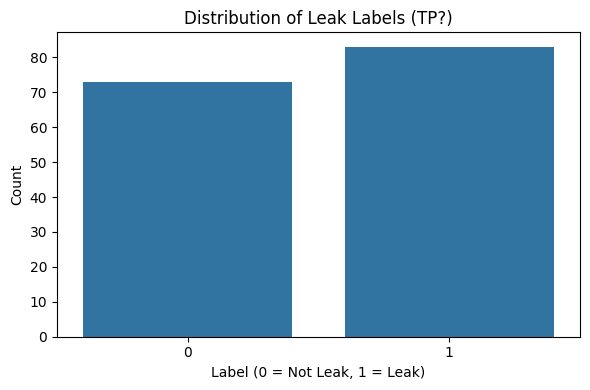

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x="TP?", data=df)
plt.title("Distribution of Leak Labels (TP?)")
plt.xlabel("Label (0 = Not Leak, 1 = Leak)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [6]:
df["TP?"].value_counts()

TP?
1    83
0    73
Name: count, dtype: int64

In [7]:
y = np.array([df['TP?']]).T

In [8]:
def draw_confusion_matrix (model, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(cmap=plt.cm.Blues,values_format='g')
    cm_display.ax_.set_title(model)
    plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    models = {
        "LogisticRegression()": LogisticRegression(),
        "DecisionTreeClassifier()": DecisionTreeClassifier(),
        "RandomForestClassifier()": RandomForestClassifier(),
        "AdaBoostClassifier()": AdaBoostClassifier(),
        "ExtraTreesClassifier()": ExtraTreesClassifier(),
        "XGBClassifier()": XGBClassifier(),
        "LGBMClassifier()": LGBMClassifier(),
        "SVC()": SVC(),
        "GaussianNB()": GaussianNB(),
        "KNeighborsClassifier()": KNeighborsClassifier(),
        "SGDClassifier()": SGDClassifier(),
        "MLPClassifier()": MLPClassifier(),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        draw_confusion_matrix (name, y_test, y_pred)
        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report


In [10]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

### MPL

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-07-18 19:04:55.361752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

## Byte Frequency

In [13]:
from scripts.feature_extractions.byte_freq import get_byte_freq_from_files

In [14]:
X  = get_byte_freq_from_files(hex_files)
X.head()

100%|██████████| 156/156 [00:00<00:00, 322.54it/s]


,60,80,40,52,04,36,10,61,00,db,...,f6,3f,d4,e7,be,f0,e4,7e,27,9e
address,,,,,,,,,,,,,,,,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,386,175,47.0,115.0,36.0,10,14.0,126.0,185.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,418,78,61.0,118.0,44.0,10,11.0,218.0,93.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,668,123,79.0,188.0,85.0,25,22.0,420.0,118.0,4.0,...,4.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,0.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,270,92,45.0,82.0,28.0,8,14.0,136.0,57.0,0.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,815,248,122.0,256.0,63.0,21,51.0,350.0,146.0,3.0,...,1.0,2.0,0.0,1.0,5.0,8.0,3.0,5.0,3.0,0.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

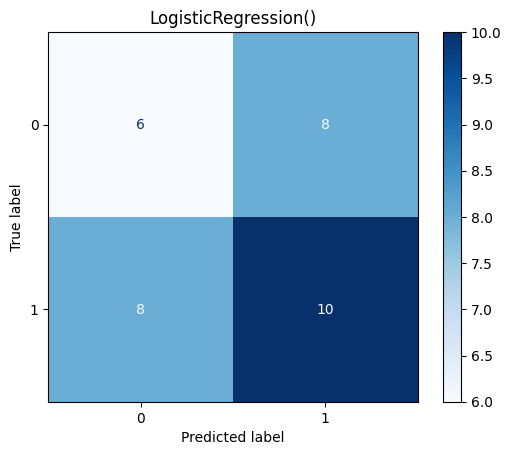

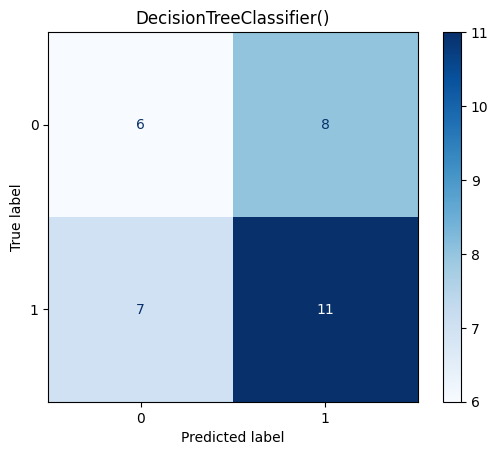

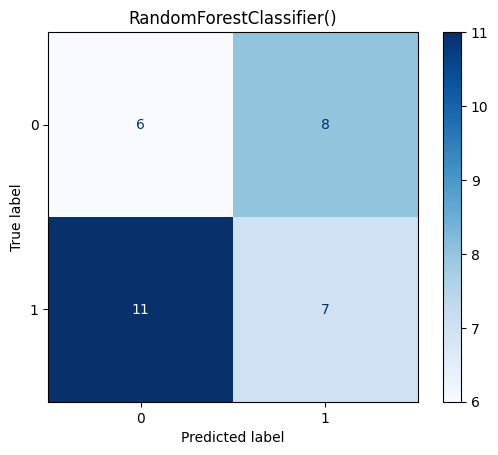

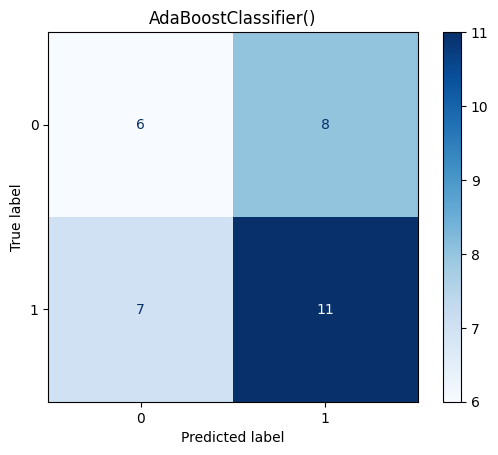

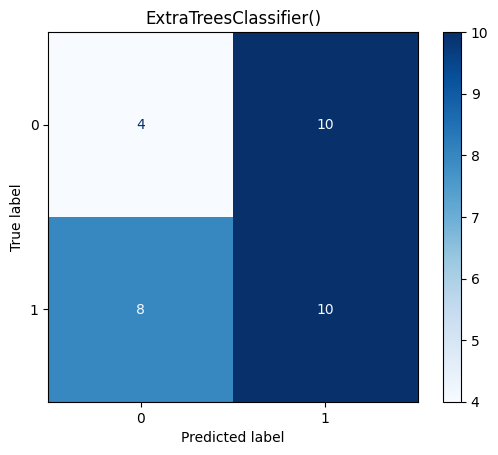

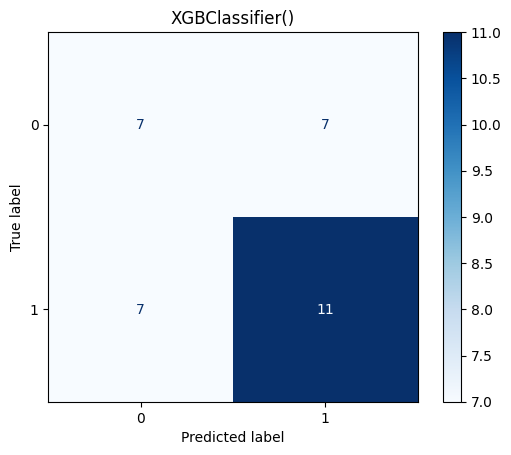

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

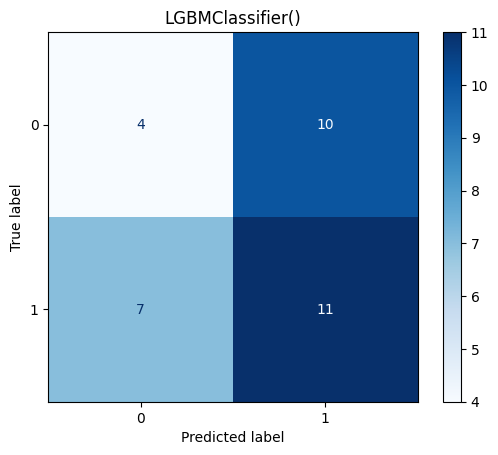

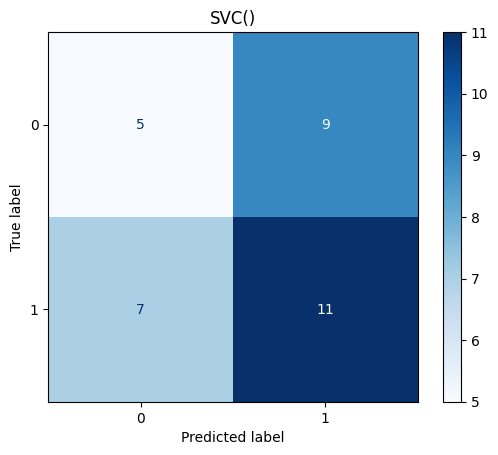

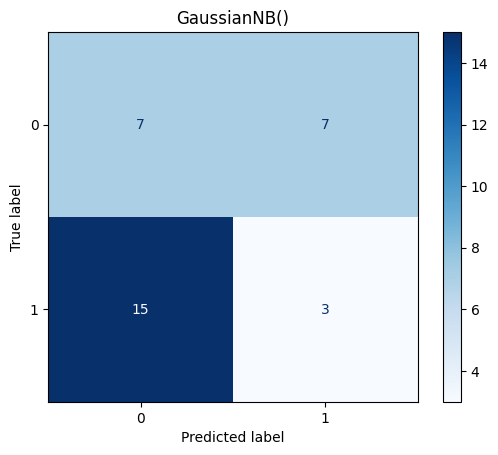

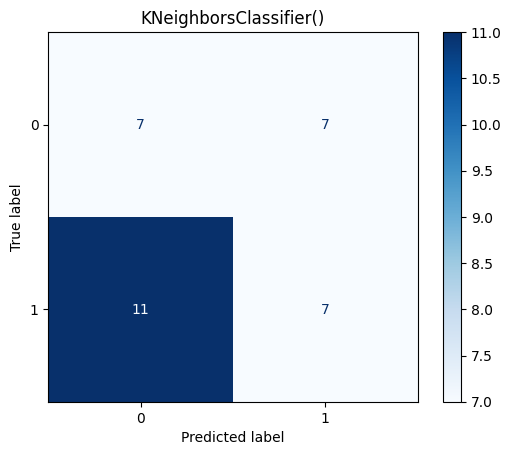

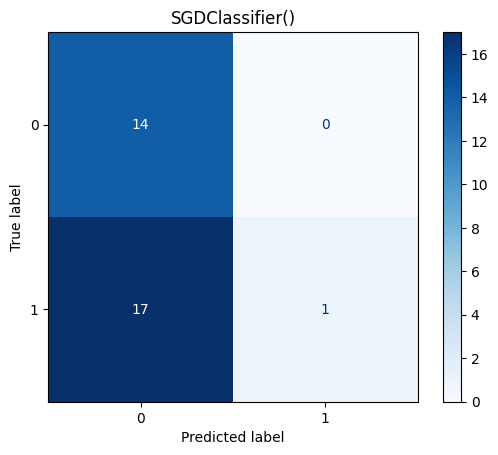

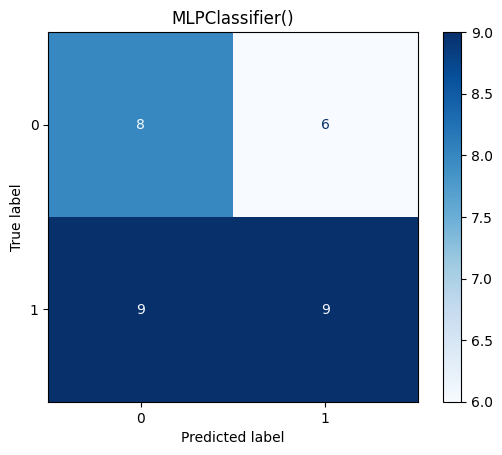

,Model,Precision,Recall,F1-score
0,XGBClassifier(),0.555556,0.555556,0.555556
1,MLPClassifier(),0.535294,0.535714,0.530792
2,DecisionTreeClassifier(),0.520243,0.519841,0.519520
3,AdaBoostClassifier(),0.520243,0.519841,0.519520
4,LogisticRegression(),0.492063,0.492063,0.492063
5,SVC(),0.483333,0.484127,0.481781
6,LGBMClassifier(),0.443723,0.448413,0.442051
7,KNeighborsClassifier(),0.444444,0.444444,0.437500
8,ExtraTreesClassifier(),0.416667,0.420635,0.417004
9,RandomForestClassifier(),0.409804,0.408730,0.405670


In [16]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [17]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.4899 - loss: 0.8861 - val_accuracy: 0.4400 - val_loss: 3.1743 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5002 - loss: 0.8050 - val_accuracy: 0.4400 - val_loss: 1.9334 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4372 - loss: 0.8956 - val_accuracy: 0.4400 - val_loss: 1.5078 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4546 - loss: 0.8795 - val_accuracy: 0.4400 - val_loss: 1.3545 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4272 - loss: 0.8875 - val_accuracy: 0.4400 - val_loss: 1.2417 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4917 - loss: 0.8307 - val_accuracy: 0.4800 - val_loss: 1.1414 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4279 - loss

In [18]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.7200


In [19]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.56      1.00      0.72        18

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32



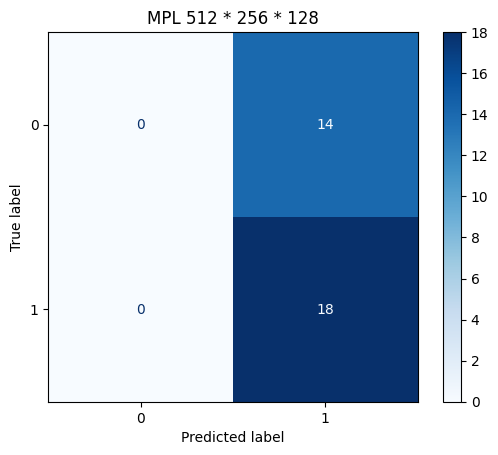

In [21]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## Graph Statistic

In [22]:

from scripts.feature_extractions.graphs import get_graphs_stat_from_files

In [23]:
X  = get_graphs_stat_from_files(hex_files)
X.head()

100%|██████████| 156/156 [01:01<00:00,  2.53it/s]


,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,155,118,1.522581,0.004943,44,0.000000
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,194,96,0.989691,0.002564,112,0.012027
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,339,178,1.050147,0.001553,192,0.003933
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,113,78,1.380531,0.006163,46,0.000000
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,303,211,1.392739,0.002306,122,0.007701


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

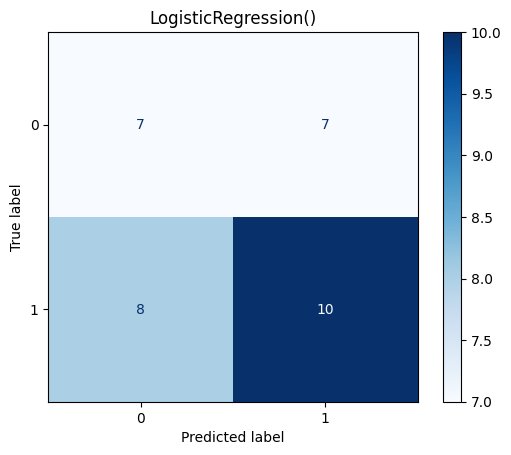

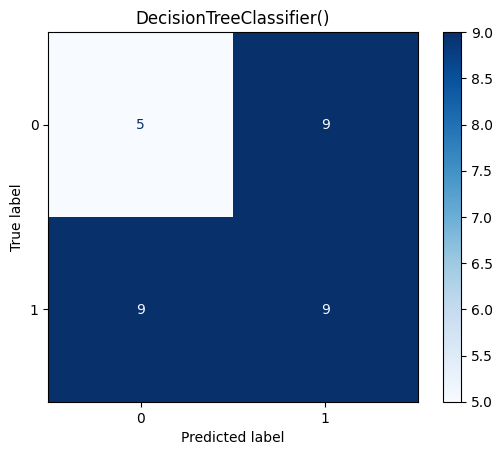

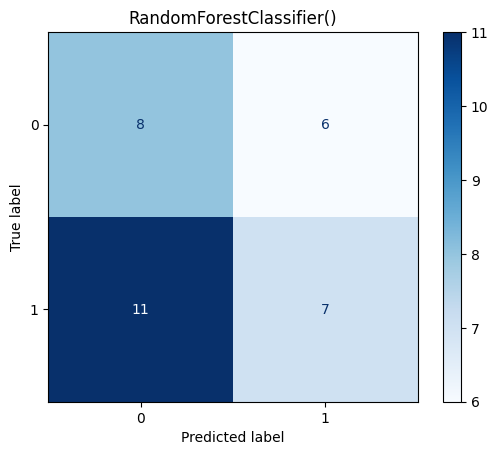

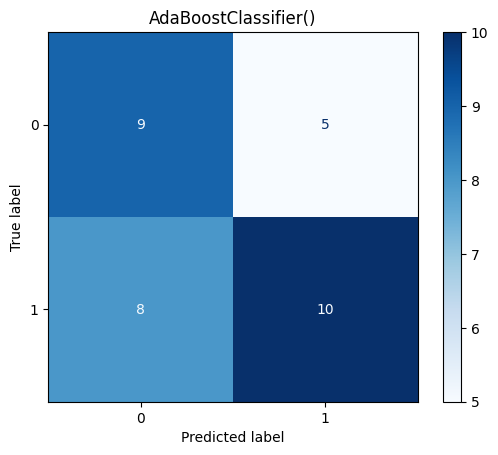

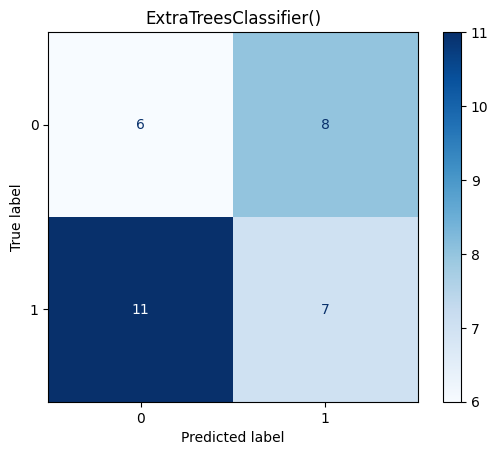

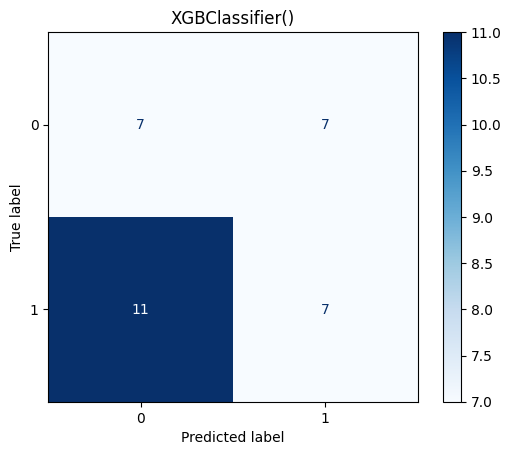

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

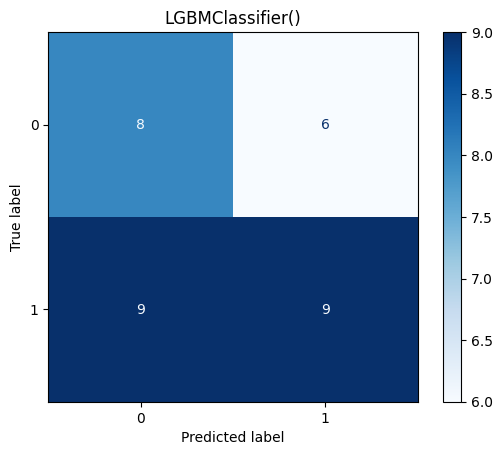

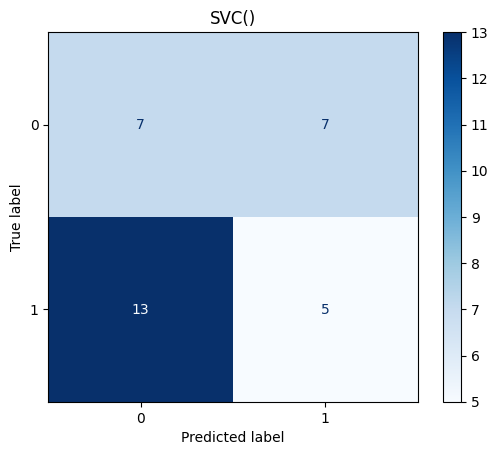

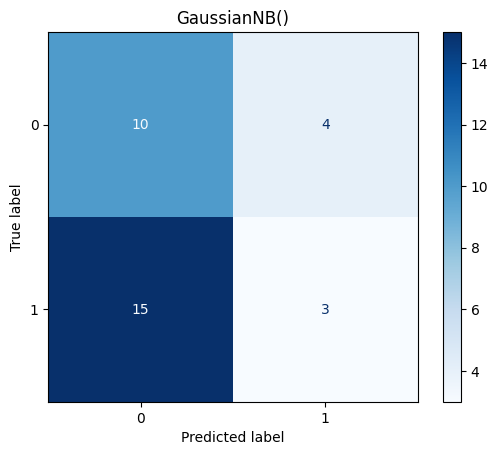

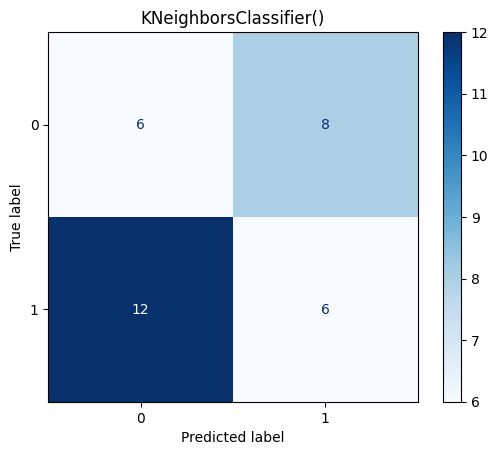

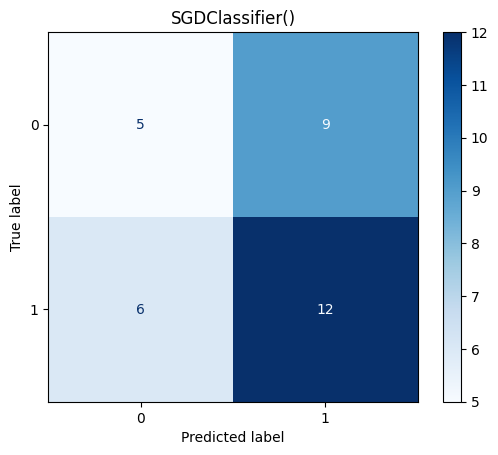

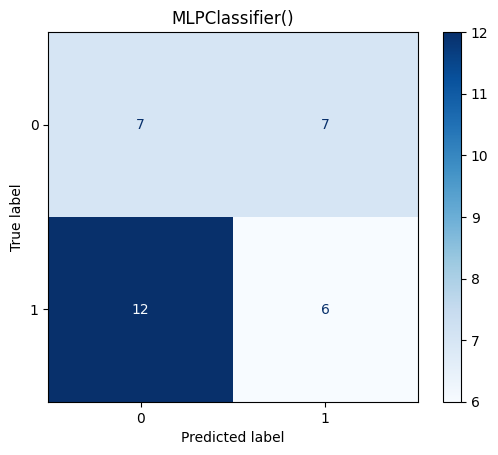

,Model,Precision,Recall,F1-score
0,AdaBoostClassifier(),0.598039,0.599206,0.593353
1,LGBMClassifier(),0.535294,0.535714,0.530792
2,LogisticRegression(),0.527451,0.527778,0.527094
3,SGDClassifier(),0.512987,0.511905,0.507692
4,RandomForestClassifier(),0.479757,0.480159,0.468231
5,XGBClassifier(),0.444444,0.444444,0.437500
6,DecisionTreeClassifier(),0.428571,0.428571,0.428571
7,ExtraTreesClassifier(),0.409804,0.408730,0.405670
8,MLPClassifier(),0.414980,0.416667,0.405670
9,GaussianNB(),0.414286,0.440476,0.376410


In [25]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [26]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5537 - loss: 0.7678 - val_accuracy: 0.5600 - val_loss: 0.8933 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5630 - loss: 0.7298 - val_accuracy: 0.6000 - val_loss: 0.8057 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5741 - loss: 0.6655 - val_accuracy: 0.6000 - val_loss: 0.7632 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5206 - loss: 0.8001 - val_accuracy: 0.6000 - val_loss: 0.7457 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4374 - loss: 0.7871 - val_accuracy: 0.5200 - val_loss: 0.7351 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4981 - loss: 0.8611 - val_accuracy: 0.5600 - val_loss: 0.7176 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4422 - loss

In [27]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Label 0: Best threshold = 0.48, Best f1 = 0.7347


In [28]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.58      1.00      0.73        18

    accuracy                           0.59        32
   macro avg       0.79      0.54      0.43        32
weighted avg       0.76      0.59      0.47        32



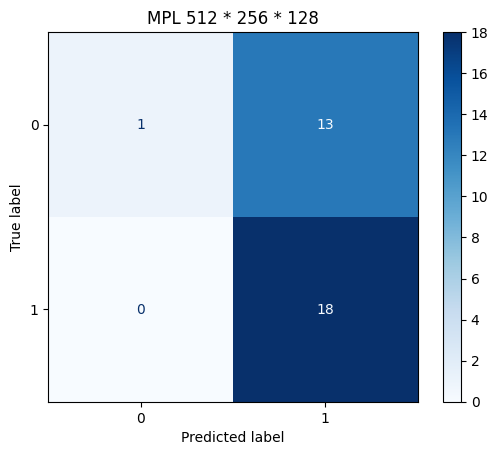

In [30]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## N-Grams

In [31]:

from scripts.feature_extractions.n_grams import get_n_grams_from_files

In [32]:
X  = get_n_grams_from_files(hex_files)
X.head()

 10%|▉         | 15/156 [00:00<00:04, 29.46it/s]invalid instruction: PUSH30
invalid instruction: PUSH17
invalid instruction: PUSH31
 12%|█▏        | 19/156 [00:00<00:04, 32.05it/s]invalid instruction: PUSH14
invalid instruction: PUSH28
 15%|█▍        | 23/156 [00:01<00:06, 19.35it/s]invalid instruction: PUSH30
invalid instruction: PUSH30
invalid instruction: PUSH24
 17%|█▋        | 27/156 [00:01<00:05, 22.66it/s]invalid instruction: PUSH27
invalid instruction: PUSH30
invalid instruction: PUSH27
 19%|█▉        | 30/156 [00:01<00:06, 20.93it/s]invalid instruction: PUSH24
invalid instruction: PUSH30
invalid instruction: PUSH16
 22%|██▏       | 35/156 [00:01<00:04, 26.10it/s]invalid instruction: PUSH23
invalid instruction: PUSH8
invalid instruction: PUSH17
 25%|██▌       | 39/156 [00:01<00:04, 28.38it/s]invalid instruction: PUSH8
invalid instruction: PUSH15
 28%|██▊       | 43/156 [00:01<00:05, 20.17it/s]invalid instruction: PUSH5
invalid instruction: PUSH10
invalid instruction: PUSH32
inv

,add add,add and,add and dup,add calldataload,add calldataload push,add calldataload swap,add dup,add dup add,add dup dup,add dup mload,...,unknown dup revert,unknown jumpdest,unknown jumpdest div,unknown jumpdest push,unknown jumpdest swap,unknown push,unknown swap,unknown swap dup,unknown unknown,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,0,0,0,0,0,0,6,0,6,0,...,0,2,0,0,0,0,0,0,3,0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,2,0,0,2,0,2,3,1,0,0,...,0,0,0,0,0,1,0,0,2,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,3,0,0,2,0,2,9,1,3,0,...,0,0,0,0,0,0,0,0,6,4
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,0,0,0,7,5,1,22,2,14,0,...,0,0,0,0,0,2,0,0,0,0
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,0,4,4,15,9,4,64,2,30,0,...,0,0,0,0,0,2,0,0,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

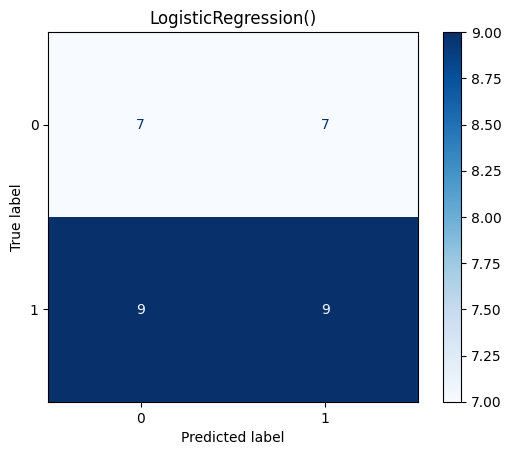

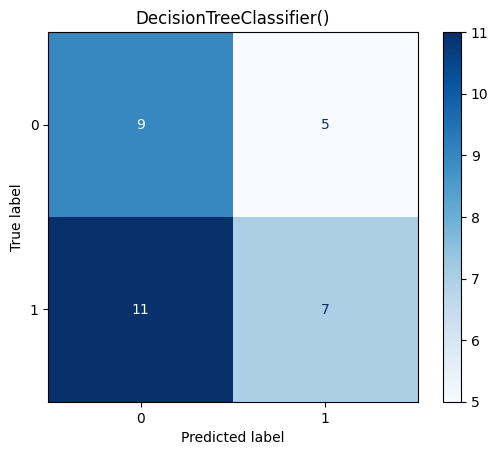

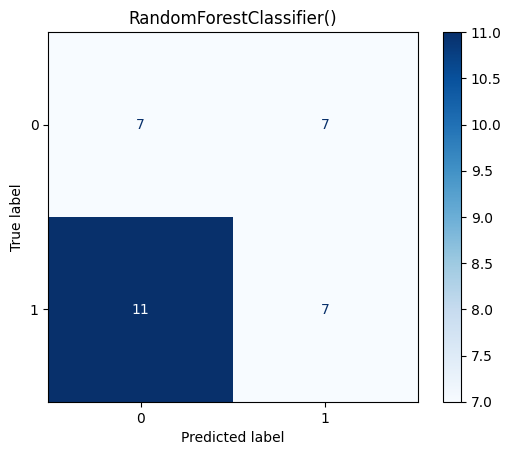

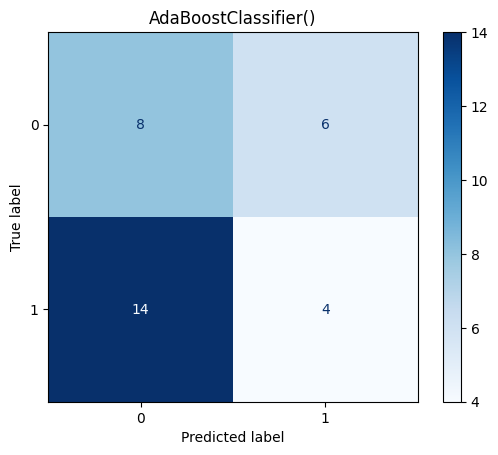

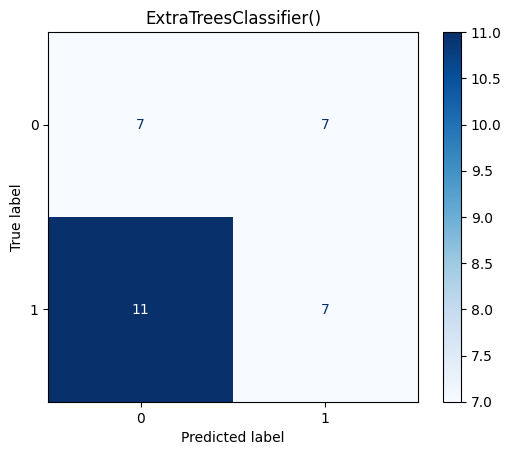

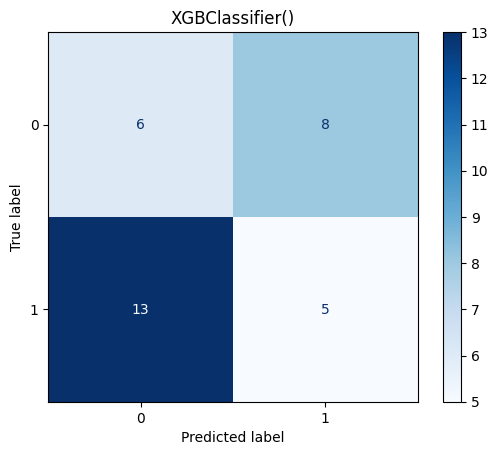

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11586
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 935
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

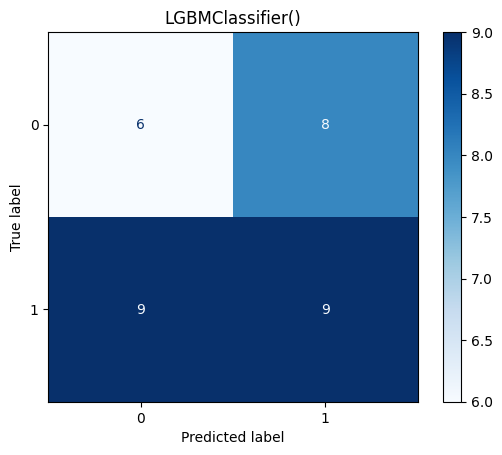

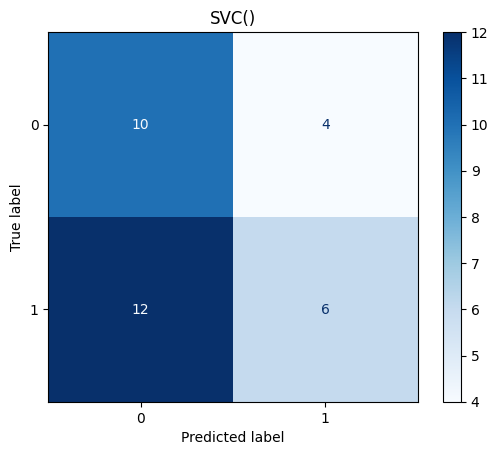

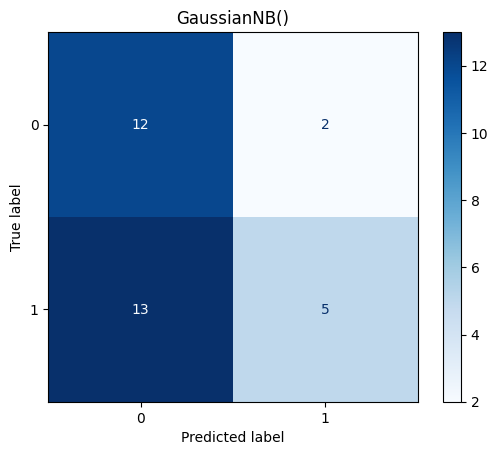

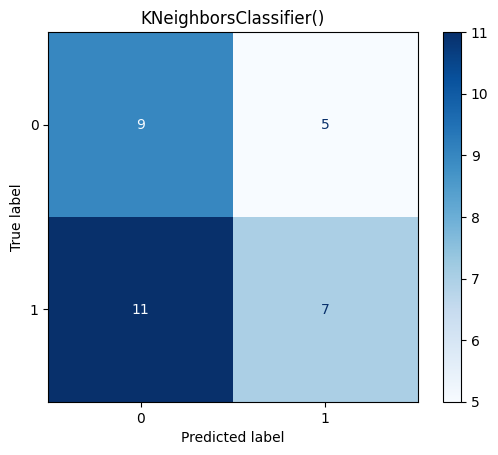

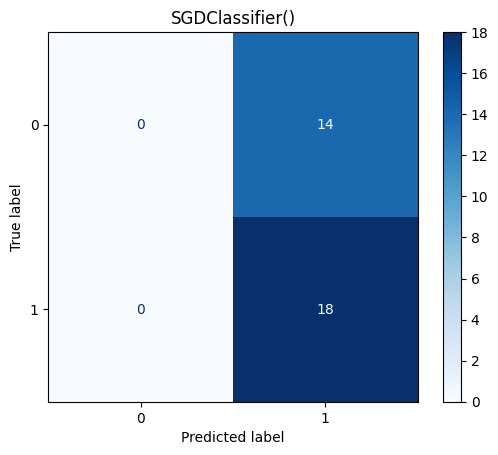

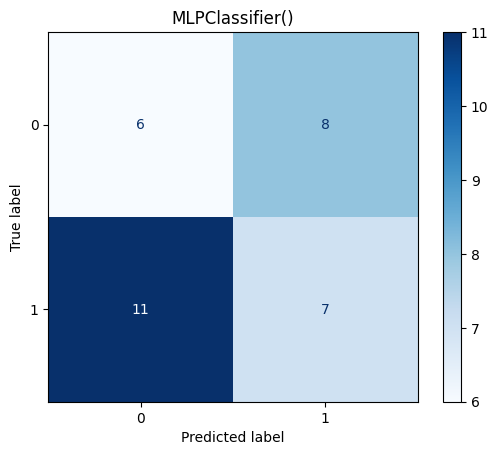

,Model,Precision,Recall,F1-score
0,GaussianNB(),0.597143,0.567460,0.507692
1,LogisticRegression(),0.500000,0.500000,0.498039
2,KNeighborsClassifier(),0.516667,0.515873,0.498039
3,DecisionTreeClassifier(),0.516667,0.515873,0.498039
4,SVC(),0.527273,0.523810,0.492063
5,LGBMClassifier(),0.464706,0.464286,0.464039
6,ExtraTreesClassifier(),0.444444,0.444444,0.437500
7,RandomForestClassifier(),0.444444,0.444444,0.437500
8,MLPClassifier(),0.409804,0.408730,0.405670
9,AdaBoostClassifier(),0.381818,0.396825,0.365079


In [34]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [35]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5238 - loss: 0.8144 - val_accuracy: 0.4000 - val_loss: 1.5062 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4909 - loss: 0.8612 - val_accuracy: 0.4000 - val_loss: 1.2157 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5708 - loss: 0.7591 - val_accuracy: 0.4400 - val_loss: 1.0885 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5218 - loss: 0.8046 - val_accuracy: 0.4400 - val_loss: 1.0174 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5548 - loss: 0.7846 - val_accuracy: 0.4400 - val_loss: 0.9626 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4521 - loss: 0.8412 - val_accuracy: 0.4800 - val_loss: 0.9149 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5144 - loss

In [36]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.7500


In [37]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25        14
           1       0.60      1.00      0.75        18

    accuracy                           0.62        32
   macro avg       0.80      0.57      0.50        32
weighted avg       0.77      0.62      0.53        32



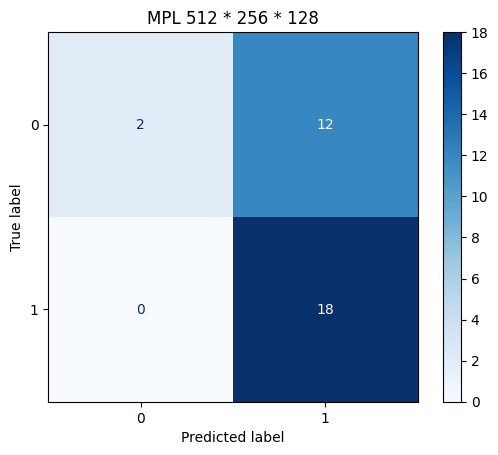

In [39]:
draw_confusion_matrix('MPL 512 * 256 * 128', y_test, y_pred)

## Opcode Frequency

In [40]:
from scripts.feature_extractions.opcode_freq import get_opcodes_freq_from_files

In [41]:
X  = get_opcodes_freq_from_files(hex_files)
X.head()

  0%|          | 0/156 [00:00<?, ?it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
 10%|▉         | 15/156 [00:00<00:06, 22.68it/s]invalid instruction: PUSH30
invalid instruction: PUSH17
invalid instruction: PUSH31
 13%|█▎        | 20/156 [00:00<00:05, 26.83it/s]invalid instruction: PUSH14
invalid instruction: PUSH28
invalid instruction: PUSH30
invalid instruction: PUSH30
 17%|█▋        | 26/156 [00:00<00:03, 32.53it/s]invalid instruction: PUSH24
invalid instruction: PUSH27
invalid instruction: PUSH30
invalid instruction: PUSH27
 20%|█▉        | 31/156 [00:01<00:05, 23.28it/s]invalid instruction: PUSH24
invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH23
 24%|██▎       | 37/156 [00:01<00:04, 29.30it/s]invalid instruction: PUSH8
invalid instruction: PUSH17
invalid instruction: PUSH8
 26%|██▋       | 41/156 [00:01<00:03, 31.31it/s]invalid instruction: PUSH15
invalid instruction: PUSH5
invalid instruction: PUSH10
invalid instruction: PUSH32
inva

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,DELEGATECALL,XOR,SDIV,SELFDESTRUCT,CALLCODE,SGT,EXTCODECOPY,BASEFEE,DIFFICULTY,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,674,112.0,10,7.0,53,17.0,326,15.0,150.0,446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,664,115.0,10,8.0,63,7.0,172,2.0,47.0,312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1155,179.0,23,13.0,101,7.0,264,4.0,76.0,517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,419,78.0,8,13.0,36,15.0,200,6.0,40.0,302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,1248,249.0,20,29.0,100,35.0,556,7.0,143.0,839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

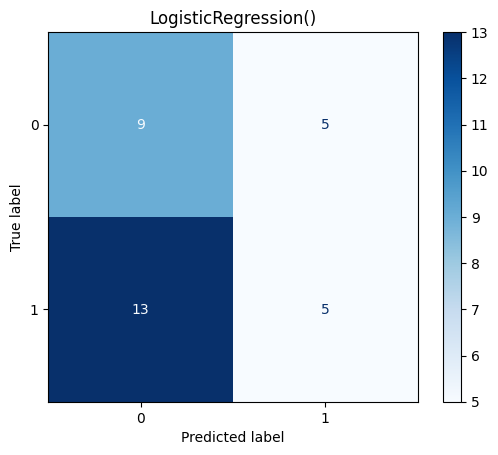

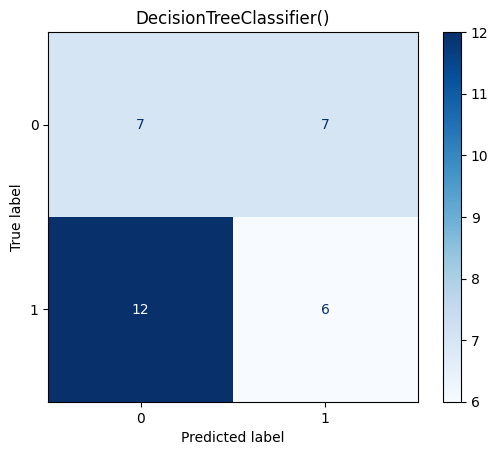

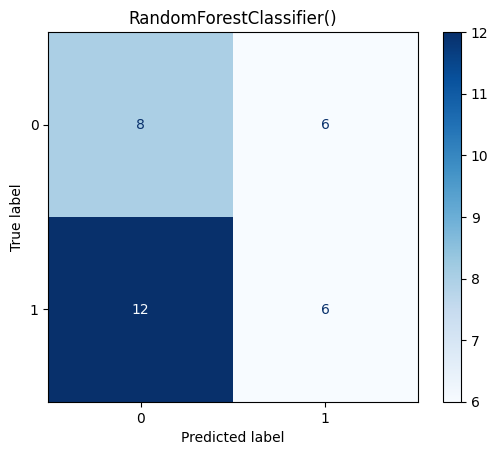

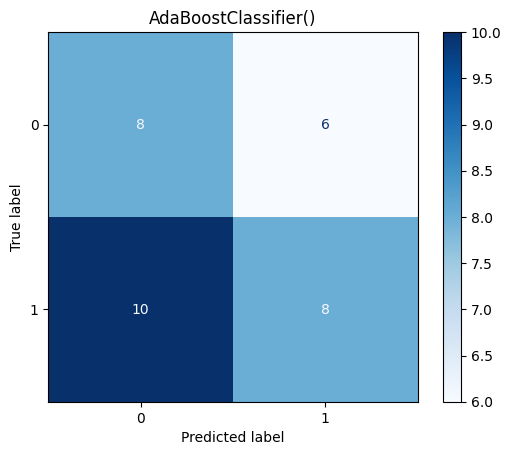

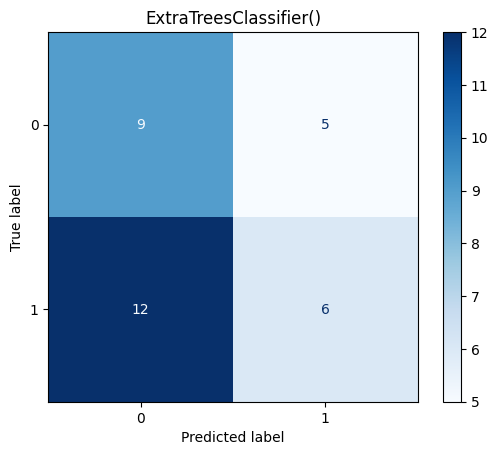

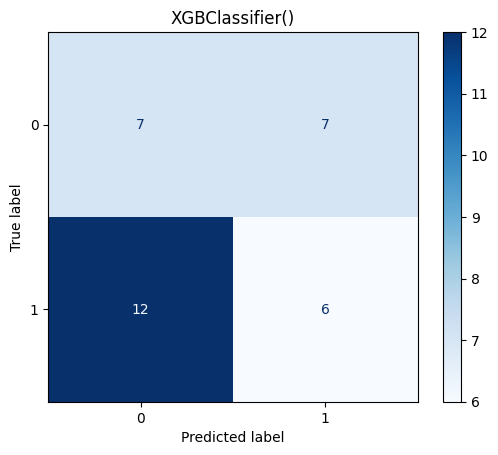

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

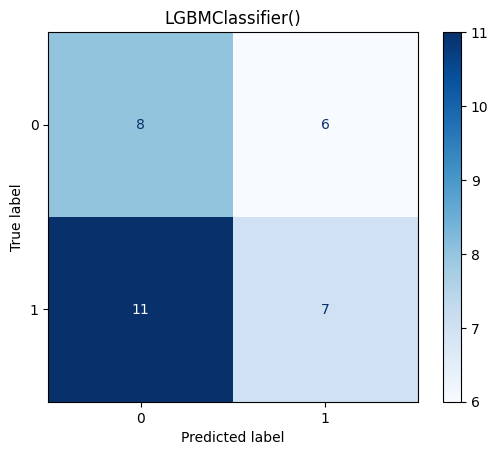

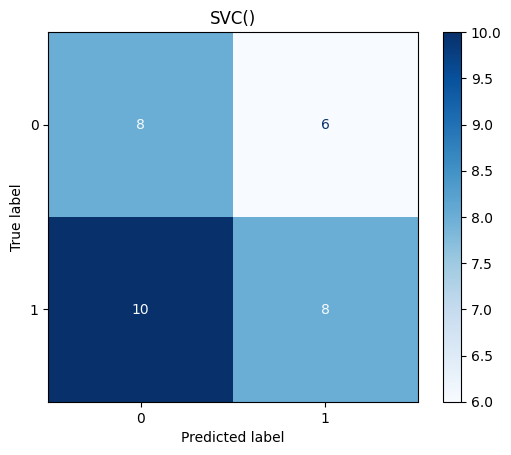

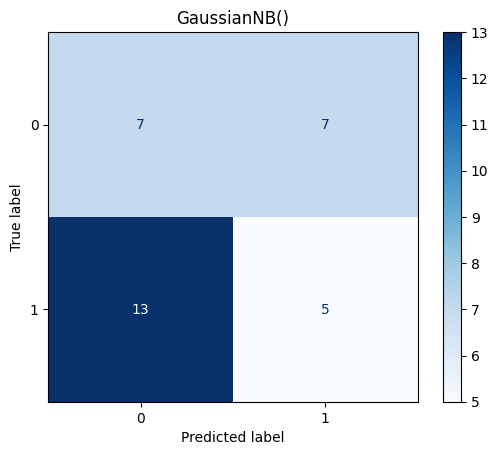

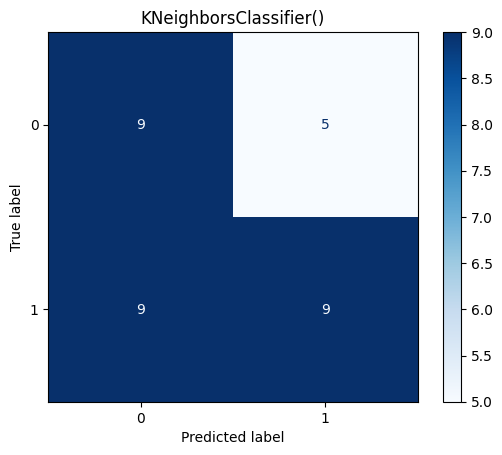

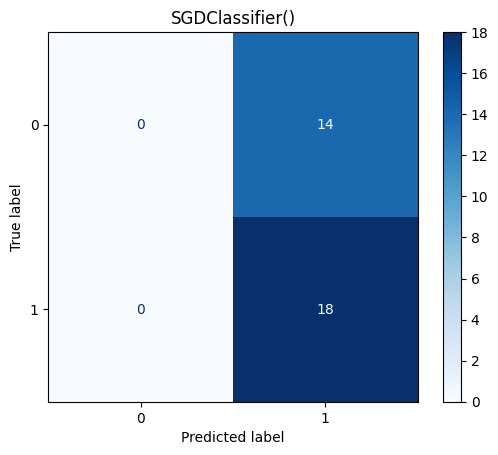

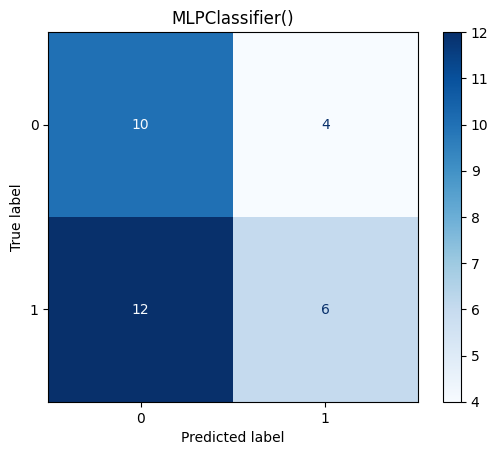

,Model,Precision,Recall,F1-score
0,KNeighborsClassifier(),0.571429,0.571429,0.562500
1,AdaBoostClassifier(),0.507937,0.507937,0.500000
2,SVC(),0.507937,0.507937,0.500000
3,MLPClassifier(),0.527273,0.523810,0.492063
4,LGBMClassifier(),0.479757,0.480159,0.468231
5,ExtraTreesClassifier(),0.487013,0.488095,0.464039
6,RandomForestClassifier(),0.450000,0.452381,0.435294
7,LogisticRegression(),0.454545,0.460317,0.428571
8,DecisionTreeClassifier(),0.414980,0.416667,0.405670
9,XGBClassifier(),0.414980,0.416667,0.405670


In [43]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [44]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5494 - loss: 0.8155 - val_accuracy: 0.4400 - val_loss: 2.1894 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6147 - loss: 0.6963 - val_accuracy: 0.4400 - val_loss: 1.6034 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5965 - loss: 0.7012 - val_accuracy: 0.4400 - val_loss: 1.2773 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5001 - loss: 0.7806 - val_accuracy: 0.4400 - val_loss: 1.1120 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4547 - loss: 0.8112 - val_accuracy: 0.4400 - val_loss: 0.9845 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5472 - loss: 0.7758 - val_accuracy: 0.4400 - val_loss: 0.8868 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5188 - loss

In [45]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7234


In [46]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.14      0.24        14
           1       0.59      0.94      0.72        18

    accuracy                           0.59        32
   macro avg       0.63      0.54      0.48        32
weighted avg       0.62      0.59      0.51        32



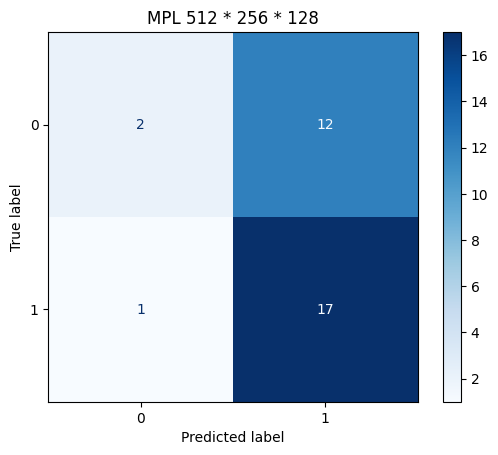

In [48]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## TF-IDF

### Hex

In [49]:
from scripts.feature_extractions.tf_idf import get_tf_idf_vector

In [50]:
X, _  = get_tf_idf_vector(hex_files)
X

100%|██████████| 156/156 [00:00<00:00, 12330.38it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 156 stored elements and shape (156, 156)>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

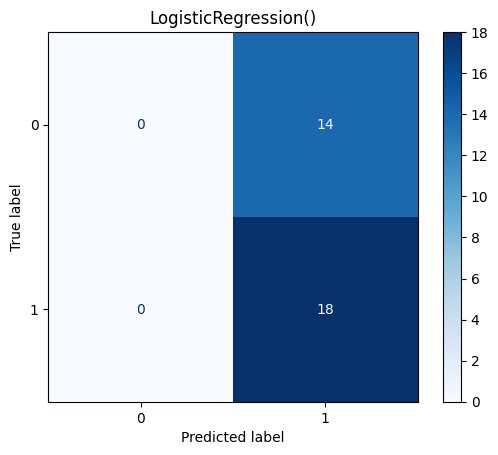

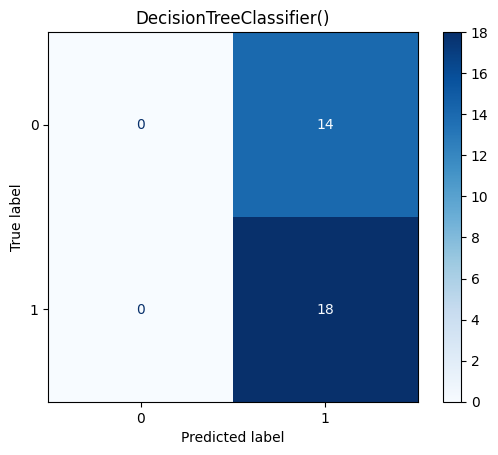

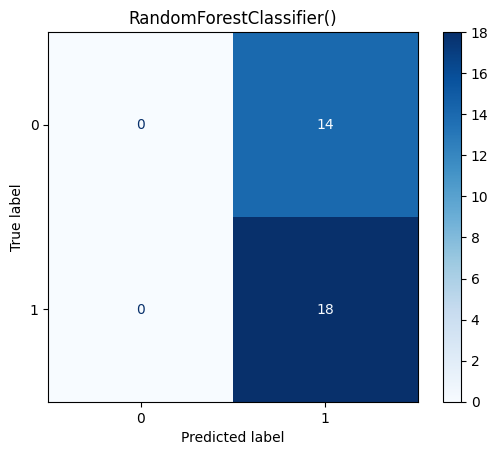

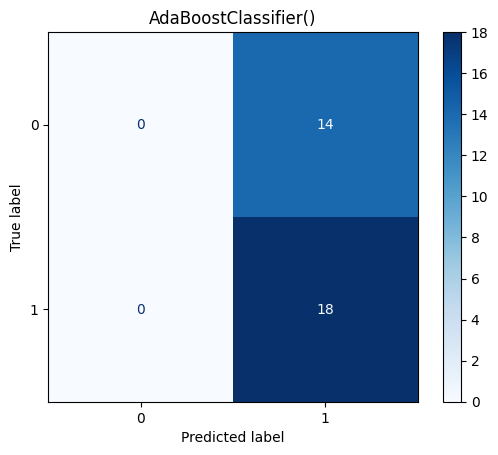

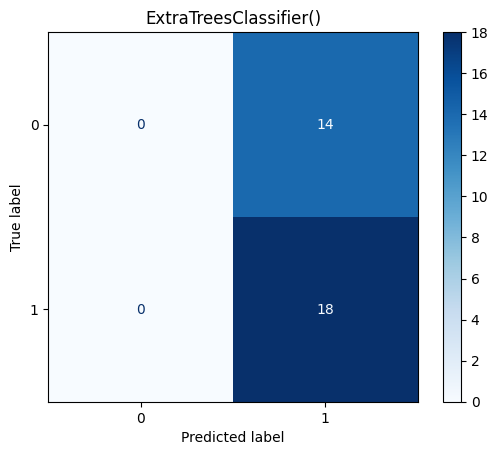

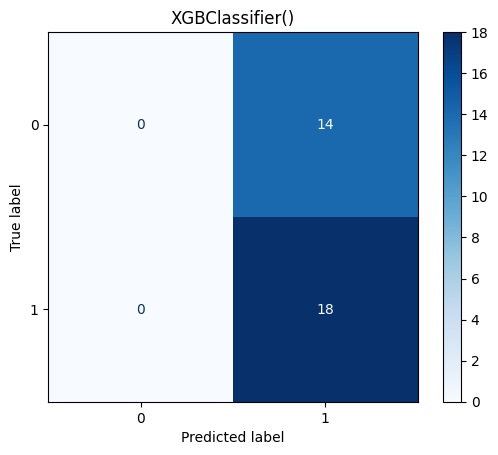

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

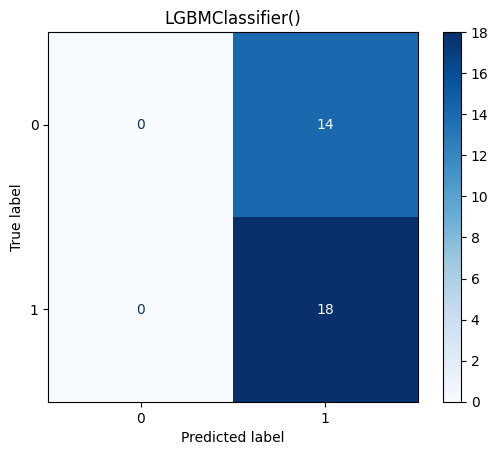

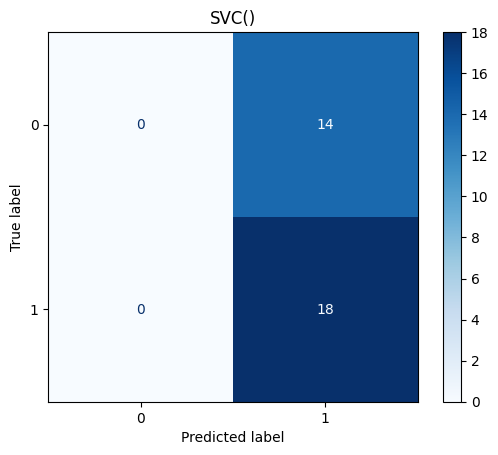

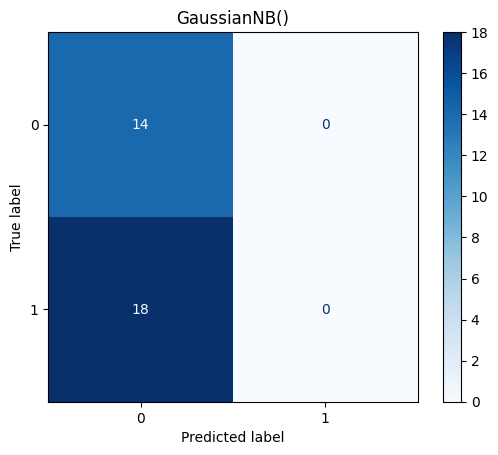

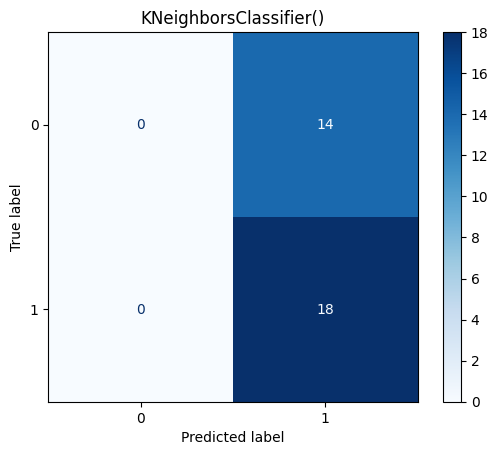

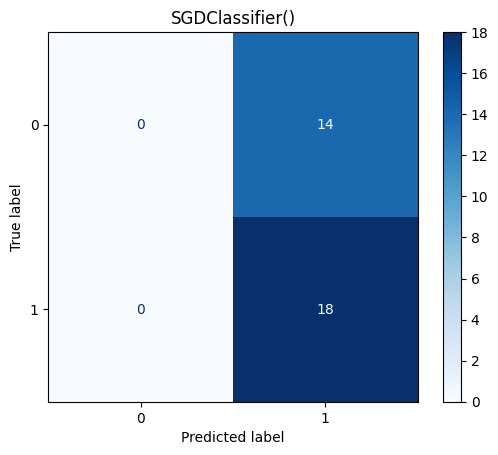

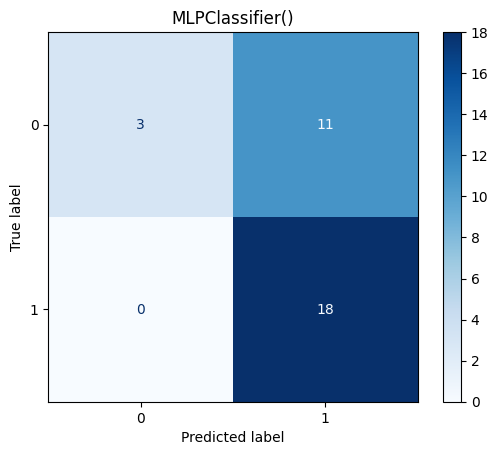

,Model,Precision,Recall,F1-score
0,MLPClassifier(),0.810345,0.607143,0.559449
1,LogisticRegression(),0.281250,0.500000,0.360000
2,RandomForestClassifier(),0.281250,0.500000,0.360000
3,DecisionTreeClassifier(),0.281250,0.500000,0.360000
4,AdaBoostClassifier(),0.281250,0.500000,0.360000
5,ExtraTreesClassifier(),0.281250,0.500000,0.360000
6,LGBMClassifier(),0.281250,0.500000,0.360000
7,XGBClassifier(),0.281250,0.500000,0.360000
8,SVC(),0.281250,0.500000,0.360000
9,KNeighborsClassifier(),0.281250,0.500000,0.360000


In [52]:
df_report = get_report_all_ml(X_train.toarray(), y_train, X_test.toarray(), y_test)
df_report

#### MPL Train & Evaluation

In [53]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4631 - loss: 0.8599 - val_accuracy: 0.5200 - val_loss: 0.7069 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4796 - loss: 0.8941 - val_accuracy: 0.6000 - val_loss: 0.7063 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3976 - loss: 0.9794 - val_accuracy: 0.5600 - val_loss: 0.7047 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4127 - loss: 0.9287 - val_accuracy: 0.5600 - val_loss: 0.7037 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5196 - loss: 0.7972 - val_accuracy: 0.5600 - val_loss: 0.7022 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4619 - loss: 0.8382 - val_accuracy: 0.5600 - val_loss: 0.7014 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5514 - loss

In [54]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Label 0: Best threshold = 0.54, Best f1 = 0.7391


In [55]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.21      0.33        14
           1       0.61      0.94      0.74        18

    accuracy                           0.62        32
   macro avg       0.68      0.58      0.54        32
weighted avg       0.67      0.62      0.56        32



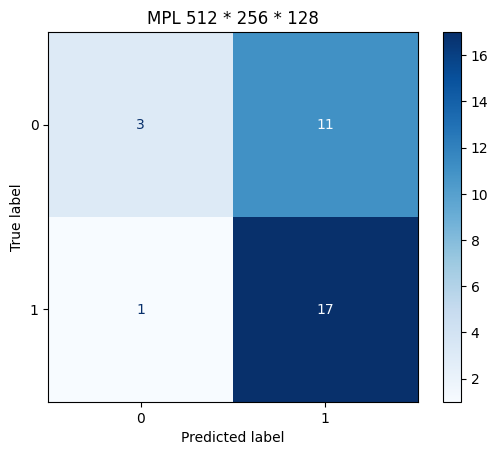

In [57]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

### Sol

In [58]:
X, _  = get_tf_idf_vector(sol_files)
X

100%|██████████| 156/156 [00:00<00:00, 1188.71it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 59032 stored elements and shape (156, 10000)>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

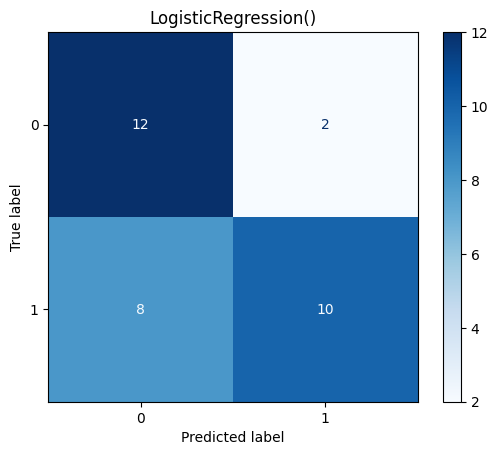

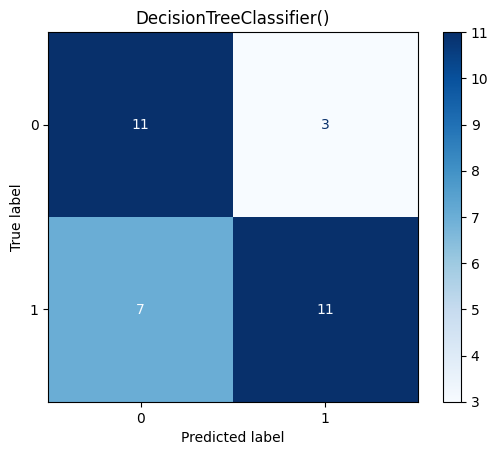

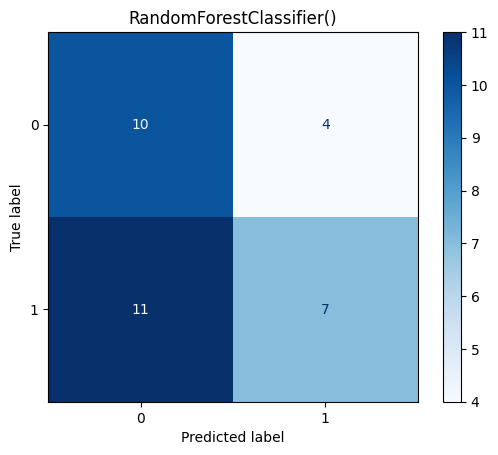

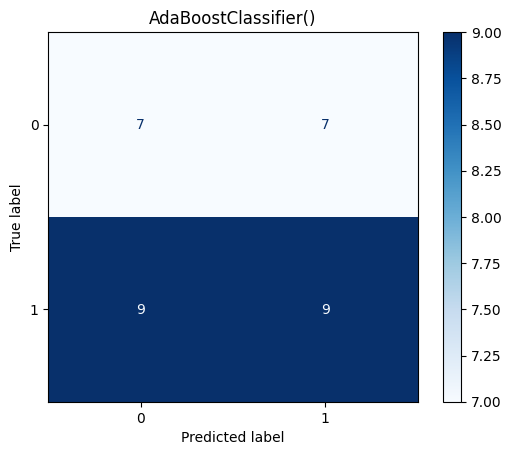

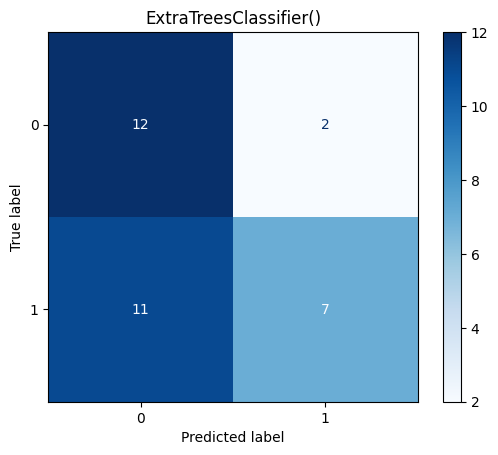

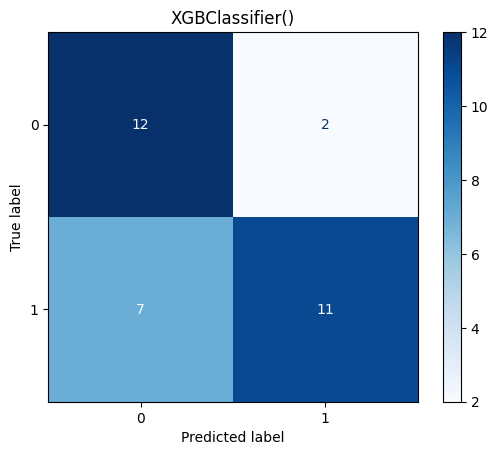

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9962
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

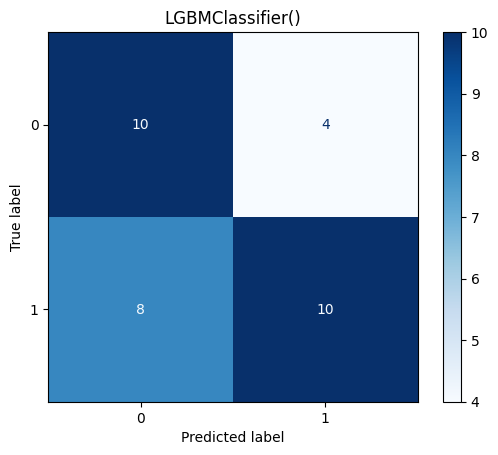

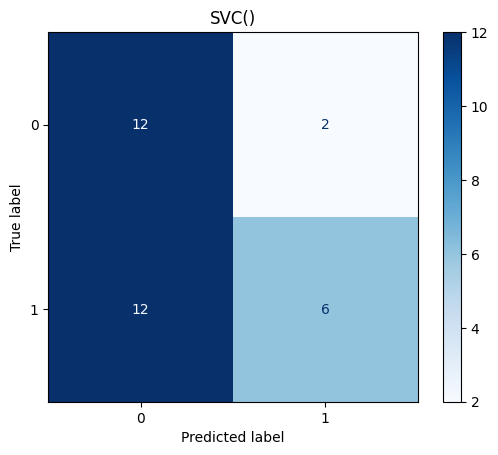

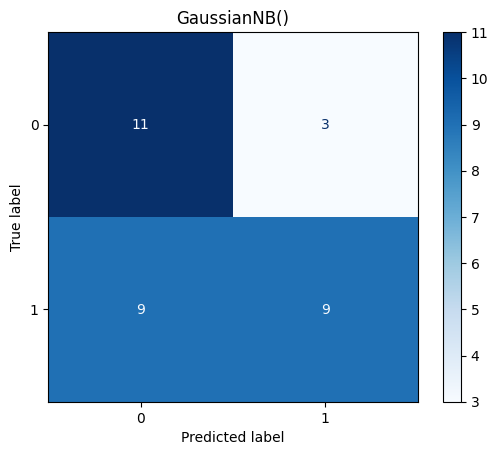

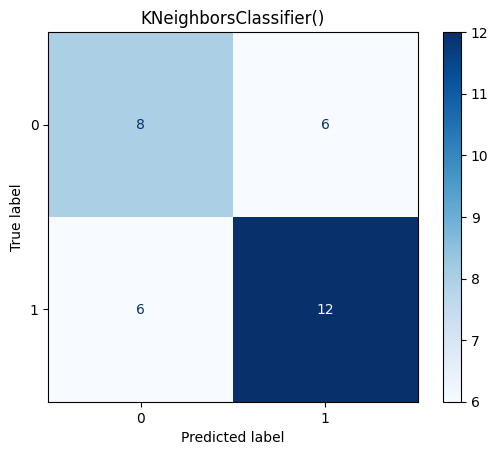

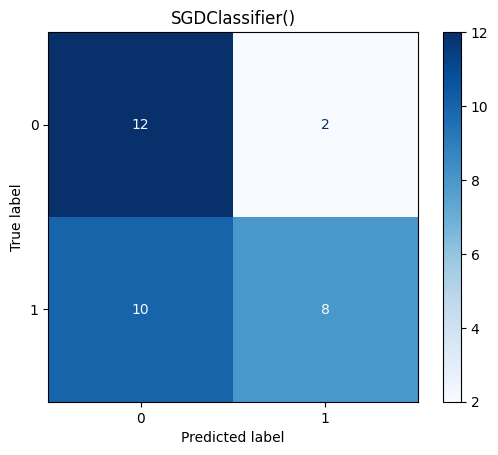

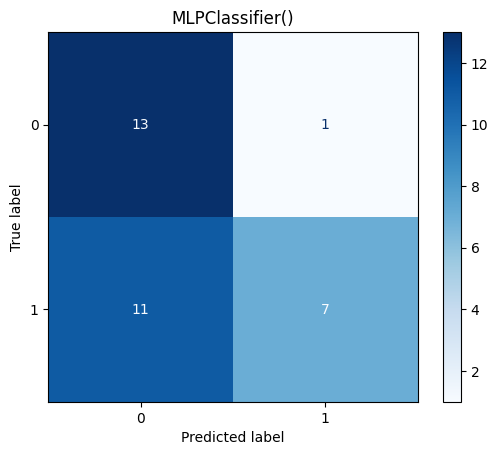

,Model,Precision,Recall,F1-score
0,XGBClassifier(),0.738866,0.734127,0.718475
1,DecisionTreeClassifier(),0.698413,0.698413,0.687500
2,LogisticRegression(),0.716667,0.706349,0.686275
3,LGBMClassifier(),0.634921,0.634921,0.625000
4,GaussianNB(),0.650000,0.642857,0.623529
5,KNeighborsClassifier(),0.619048,0.619048,0.619048
6,SGDClassifier(),0.672727,0.650794,0.619048
7,MLPClassifier(),0.708333,0.658730,0.611336
8,ExtraTreesClassifier(),0.649758,0.623016,0.583584
9,SVC(),0.625000,0.595238,0.546559


In [60]:
df_report = get_report_all_ml(X_train.toarray(), y_train, X_test.toarray(), y_test)
df_report

#### MPL Train & Evaluation

In [61]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.6372 - loss: 0.7041 - val_accuracy: 0.4000 - val_loss: 0.7632 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4813 - loss: 0.9070 - val_accuracy: 0.4400 - val_loss: 0.7642 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4979 - loss: 0.8886 - val_accuracy: 0.4400 - val_loss: 0.7653 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5298 - loss: 0.8342 - val_accuracy: 0.4400 - val_loss: 0.7664 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4887 - loss: 0.8639 - val_accuracy: 0.4400 - val_loss: 0.7682 - learning_rate: 1.0000e-06
Epoch 6/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5868 - loss: 0.7866
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5905 - loss: 0.77

In [62]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.7200


In [63]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.56      1.00      0.72        18

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32



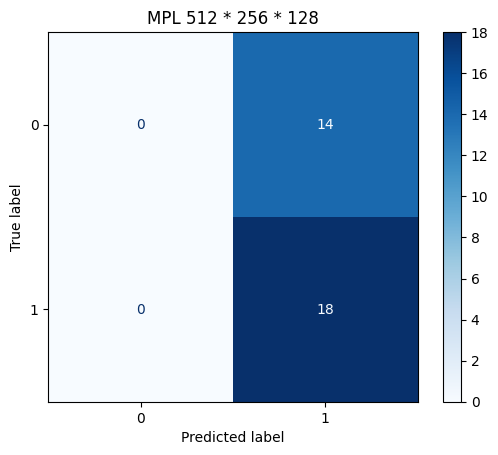

In [65]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## Save Graph Data

In [66]:
from scripts.feature_extractions.graphs import save_graphs_and_labels_from_files

save_graphs_and_labels_from_files(hex_files, y, DATA_PATH, 'graphs_for_leak.pkl')

100%|██████████| 156/156 [00:58<00:00,  2.66it/s]

saved graphs_for_leak.pkl
